# Extracting 5 visually similar artworks to user's upload image

## 1. Imports and Drive

In [ ]:
#import tensorflow as tf

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
!pip install -q transformers timm faiss-cpu

In [ ]:
import os
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import faiss
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Build embeddings with DeIT

In [ ]:
# Set paths
IMG_DIR = '/content/drive/MyDrive/art_dna/raw_data/resized'  # Full dataset directory
IMAGE_SIZE = 224  # Required input size for DeiT

In [ ]:
from huggingface_hub import login
from google.colab import userdata
import os

# Retrieve the token from Colab Secrets
hf_token = userdata.get("HF_TOKEN")

# Check if the token was retrieved successfully before attempting to login
if hf_token:
    login(token=hf_token)
else:
    print("HF_TOKEN not found in Colab Secrets.")

In [ ]:
# STEP 2: Load DeiT
from transformers import AutoImageProcessor, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "facebook/deit-base-distilled-patch16-224"
feature_extractor = AutoImageProcessor.from_pretrained(model_name) #image processor
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiTModel(
  (embeddings): DeiTEmbeddings(
    (patch_embeddings): DeiTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): DeiTEncoder(
    (layer): ModuleList(
      (0-11): 12 x DeiTLayer(
        (attention): DeiTAttention(
          (attention): DeiTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): DeiTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): DeiTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): DeiTOutput(
  

In [ ]:
# STEP 3: Image preprocessing
transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

In [ ]:
def load_image(path):
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

In [ ]:
# STEP 4: Build embeddings
def build_embeddings(img_dir, max_images=1000, save_prefix="deit"):
    """
    Extract embeddings from up to `max_images` in `img_dir`.
    """
    # Get image paths
    image_paths = [
        os.path.join(img_dir, f)
        for f in os.listdir(img_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    image_paths.sort()  # optional, for reproducibility
    image_paths = image_paths[:max_images]  # take first N images

    embeddings = []

    for path in tqdm(image_paths, desc=f"Extracting features (up to {max_images} images)"):
        try:
            img_tensor = load_image(path)
            with torch.no_grad():
                outputs = model(img_tensor)
                emb = outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()
                embeddings.append(emb)
        except Exception as e:
            print(f"Error with image {path}: {e}")

    embeddings = np.array(embeddings)

    # Save embeddings and paths
    np.save(f"{save_prefix}_embeddings.npy", embeddings)
    np.save(f"{save_prefix}_image_paths.npy", image_paths)

    print(f"✅ Saved {len(embeddings)} embeddings to {save_prefix}_embeddings.npy")
    return embeddings, image_paths

In [ ]:
# Run once to build embeddings
embeddings, image_paths = build_embeddings(IMG_DIR)

Extracting features (up to 1000 images): 100%|██████████| 1000/1000 [17:17<00:00,  1.04s/it]

✅ Saved 1000 embeddings to deit_embeddings.npy


In [ ]:
import os

save_dir = "/content/drive/MyDrive/art_dna/embeddings"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
np.save(os.path.join(save_dir, "deit_embeddings.npy"), embeddings)
np.save(os.path.join(save_dir, "deit_paths.npy"), image_paths)
print("✅ Saved embeddings and image paths as .npy files.")

✅ Saved embeddings and image paths as .npy files.


In [ ]:
import pickle

with open(os.path.join(save_dir, "deit_embeddings.pkl"), "wb") as f:
    pickle.dump((embeddings, image_paths), f)
print("✅ Also saved as pickle.")

✅ Also saved as pickle.


In [ ]:
#How to Load Them Later from .npy files:
#embeddings = np.load("/content/drive/MyDrive/art_dna/embeddings/deit_embeddings.npy")
#image_paths = np.load("/content/drive/MyDrive/art_dna/embeddings/deit_paths.npy", allow_pickle=True)

In [ ]:
#How to load from pickle
#with open("/content/drive/MyDrive/art_dna/embeddings/deit_embeddings.pkl", "rb") as f:
    #embeddings, image_paths = pickle.load(f)

##  Define search functions

In [ ]:
# Function to extract embedding from user image

def extract_embedding(image_path):
    img = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=img, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return embedding

In [ ]:
# Function to find top-k similar images
import matplotlib.pyplot as plt

def find_similar_images(upload_path, embeddings, image_paths, top_k=5):
    query_embedding = extract_embedding(upload_path)
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    top_indices = np.argsort(similarities)[::-1][:top_k]

    print("✅ Top visually similar artworks:")
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(top_indices):
        img_path = image_paths[idx]
        img = Image.open(img_path)
        plt.subplot(1, top_k, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"#{i+1}")
    plt.show()

## 4. Test ebeddings from a saved pickle (Find 5 most similar images)


In [ ]:
# Load the precomputed DeiT embeddings and corresponding image paths
with open("/content/drive/MyDrive/art_dna/embeddings/deit_embeddings.pkl", "rb") as f:
    embeddings, image_paths = pickle.load(f)

print(f"✅ Loaded {len(embeddings)} embeddings.")

✅ Loaded 1000 embeddings.


In [ ]:
# Upload an image interactively
from google.colab import files

uploaded = files.upload()

# grabs the filename of your uploaded image for use later.
upload_path = list(uploaded.keys())[0]

Saving 1.jpeg to 1.jpeg


In [ ]:
# Load precomputed embeddings and image paths:

#a NumPy array where each row is the feature vector extracted from one painting image by DeiT.
embeddings = np.load("/content/drive/MyDrive/art_dna/embeddings/deit_embeddings.npy")

#a list/array of strings with file paths to each painting corresponding to each embedding.
image_paths = np.load("/content/drive/MyDrive/art_dna/embeddings/deit_paths.npy", allow_pickle=True) # Changed to deit_paths.npy and added full path

✅ Top visually similar artworks:


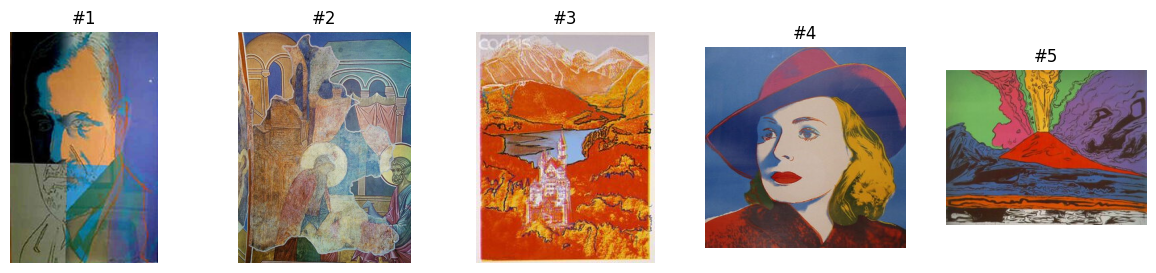

In [ ]:
# Run similarity search
find_similar_images(upload_path, embeddings, image_paths)